1. Import required libraries and define main varaibles

In [1]:
%matplotlib inline

import numpy as np
import cv2
import os
import imutils
import random
import easyocr

from glob import glob
from lxml import etree
from matplotlib import pyplot as plt

IMAGE_SIZE = 200

2. Read and resize images and save them into an array (X)

In [2]:
img_dir = "./data/images"                   # Images folder
data_path = os.path.join(img_dir,'*jpg')    # Target jpg files
files = glob(data_path)                     # Get all files in the directory (300)
files.sort()                                # Sort images by name to match them to the xml files containing the annotations of the bounding boxes

# Read files, resize images and save them into an array
X=[]
for file in files:
    img = cv2.imread(file)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

3. Parsing data from XML annotations, resize them to fit the new image sizes and save them into y

In [3]:
def resizeannotation(f):    
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):   
        xmin = int(float(dim.xpath("xmin")[0].text)) / (width / IMAGE_SIZE)
        ymin = int(float(dim.xpath("ymin")[0].text)) / (height / IMAGE_SIZE)
        xmax = int(float(dim.xpath("xmax")[0].text)) / (width / IMAGE_SIZE)
        ymax = int(float(dim.xpath("ymax")[0].text)) / (height / IMAGE_SIZE)
        
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [4]:
path = './data/annotations'
text_files = ['./data/annotations/'+f for f in sorted(os.listdir(path))]

y=[]
for i in text_files:
    y.append(resizeannotation(i))

4. Verfy X and y shapes and print the first 20 images from the dataset

In [5]:
print(np.array(X).shape, np.array(y).shape)

(300, 200, 200, 3) (300, 4)


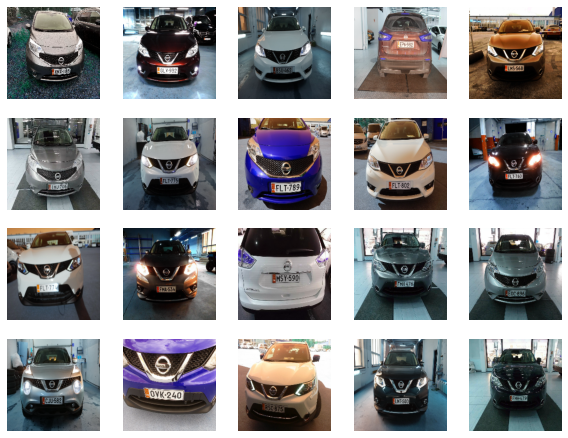

In [6]:
plt.figure(figsize=(10,20))
for i in range(0,20) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

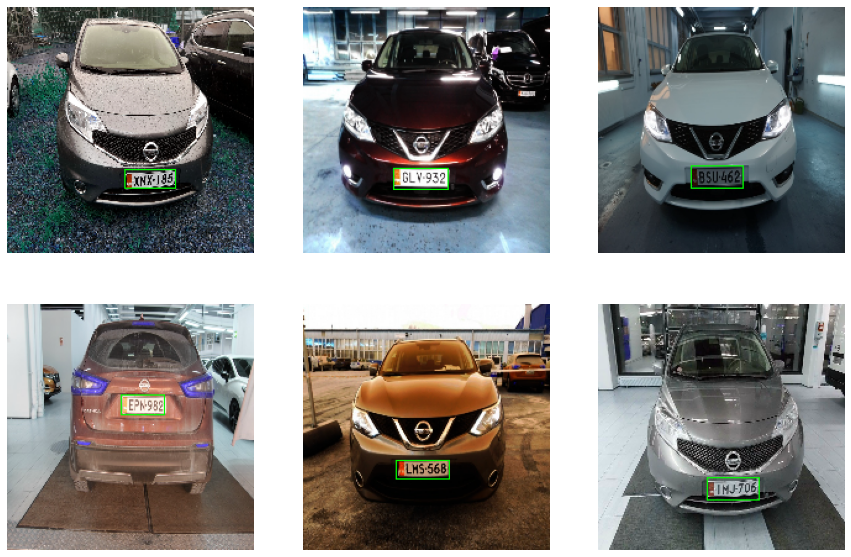

In [7]:
# Print the first 6 images including bounding boxes
plt.figure(figsize=(15,10))
for i in range(0,6) :
    plt.subplot(2,3,i+1)
    plt.axis('off')
    image = cv2.rectangle(X[i],(y[i][0],y[i][1]),(y[i][2],y[i][3]),(0, 255, 0))
    plt.imshow(image)

5. Preparing the data for the CNN

In [8]:
#Transforming in array
X=np.array(X)
y=np.array(y)

#Renormalisation
X = X / 255
y = y / 255

In [9]:
# Splitiing data into train, validations and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape

((216, 200, 200, 3),
 (24, 200, 200, 3),
 (60, 200, 200, 3),
 (216, 4),
 (24, 4),
 (60, 4))

6. Convolutional Neural Network (CNN)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,099,140
Trainable params: 2,384,452
Non

In [11]:
# Compile and train the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Add early stopper and fit the model
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1, callbacks =[earlystopping])

Epoch 1/50
7/7 [==============================] - 22s 3s/step - loss: 0.0636 - accuracy: 0.2454 - val_loss: 0.0386 - val_accuracy: 0.7500
Epoch 2/50
7/7 [==============================] - 20s 3s/step - loss: 0.0196 - accuracy: 0.4213 - val_loss: 0.0125 - val_accuracy: 0.1250
Epoch 3/50
7/7 [==============================] - 20s 3s/step - loss: 0.0072 - accuracy: 0.6759 - val_loss: 0.0101 - val_accuracy: 0.8333
Epoch 4/50
7/7 [==============================] - 20s 3s/step - loss: 0.0045 - accuracy: 0.8519 - val_loss: 0.0023 - val_accuracy: 0.7917
Epoch 5/50
7/7 [==============================] - 20s 3s/step - loss: 0.0019 - accuracy: 0.8843 - val_loss: 0.0025 - val_accuracy: 0.6667
Epoch 6/50
7/7 [==============================] - 20s 3s/step - loss: 0.0014 - accuracy: 0.8935 - val_loss: 0.0022 - val_accuracy: 0.8333
Epoch 7/50
7/7 [==============================] - 21s 3s/step - loss: 0.0011 - accuracy: 0.9306 - val_loss: 0.0025 - val_accuracy: 0.8333
Epoch 8/50
7/7 [==================

In [12]:
# Test the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 93.33%


7. Plot results

In [13]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Scores')
    plt.legend()
    plt.show()

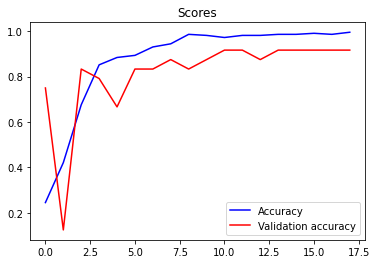

In [14]:
plot_scores(train)

8. Predict

In [15]:
 y_cnn = model.predict(X_test)

In [16]:
y_cnn.shape

(60, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

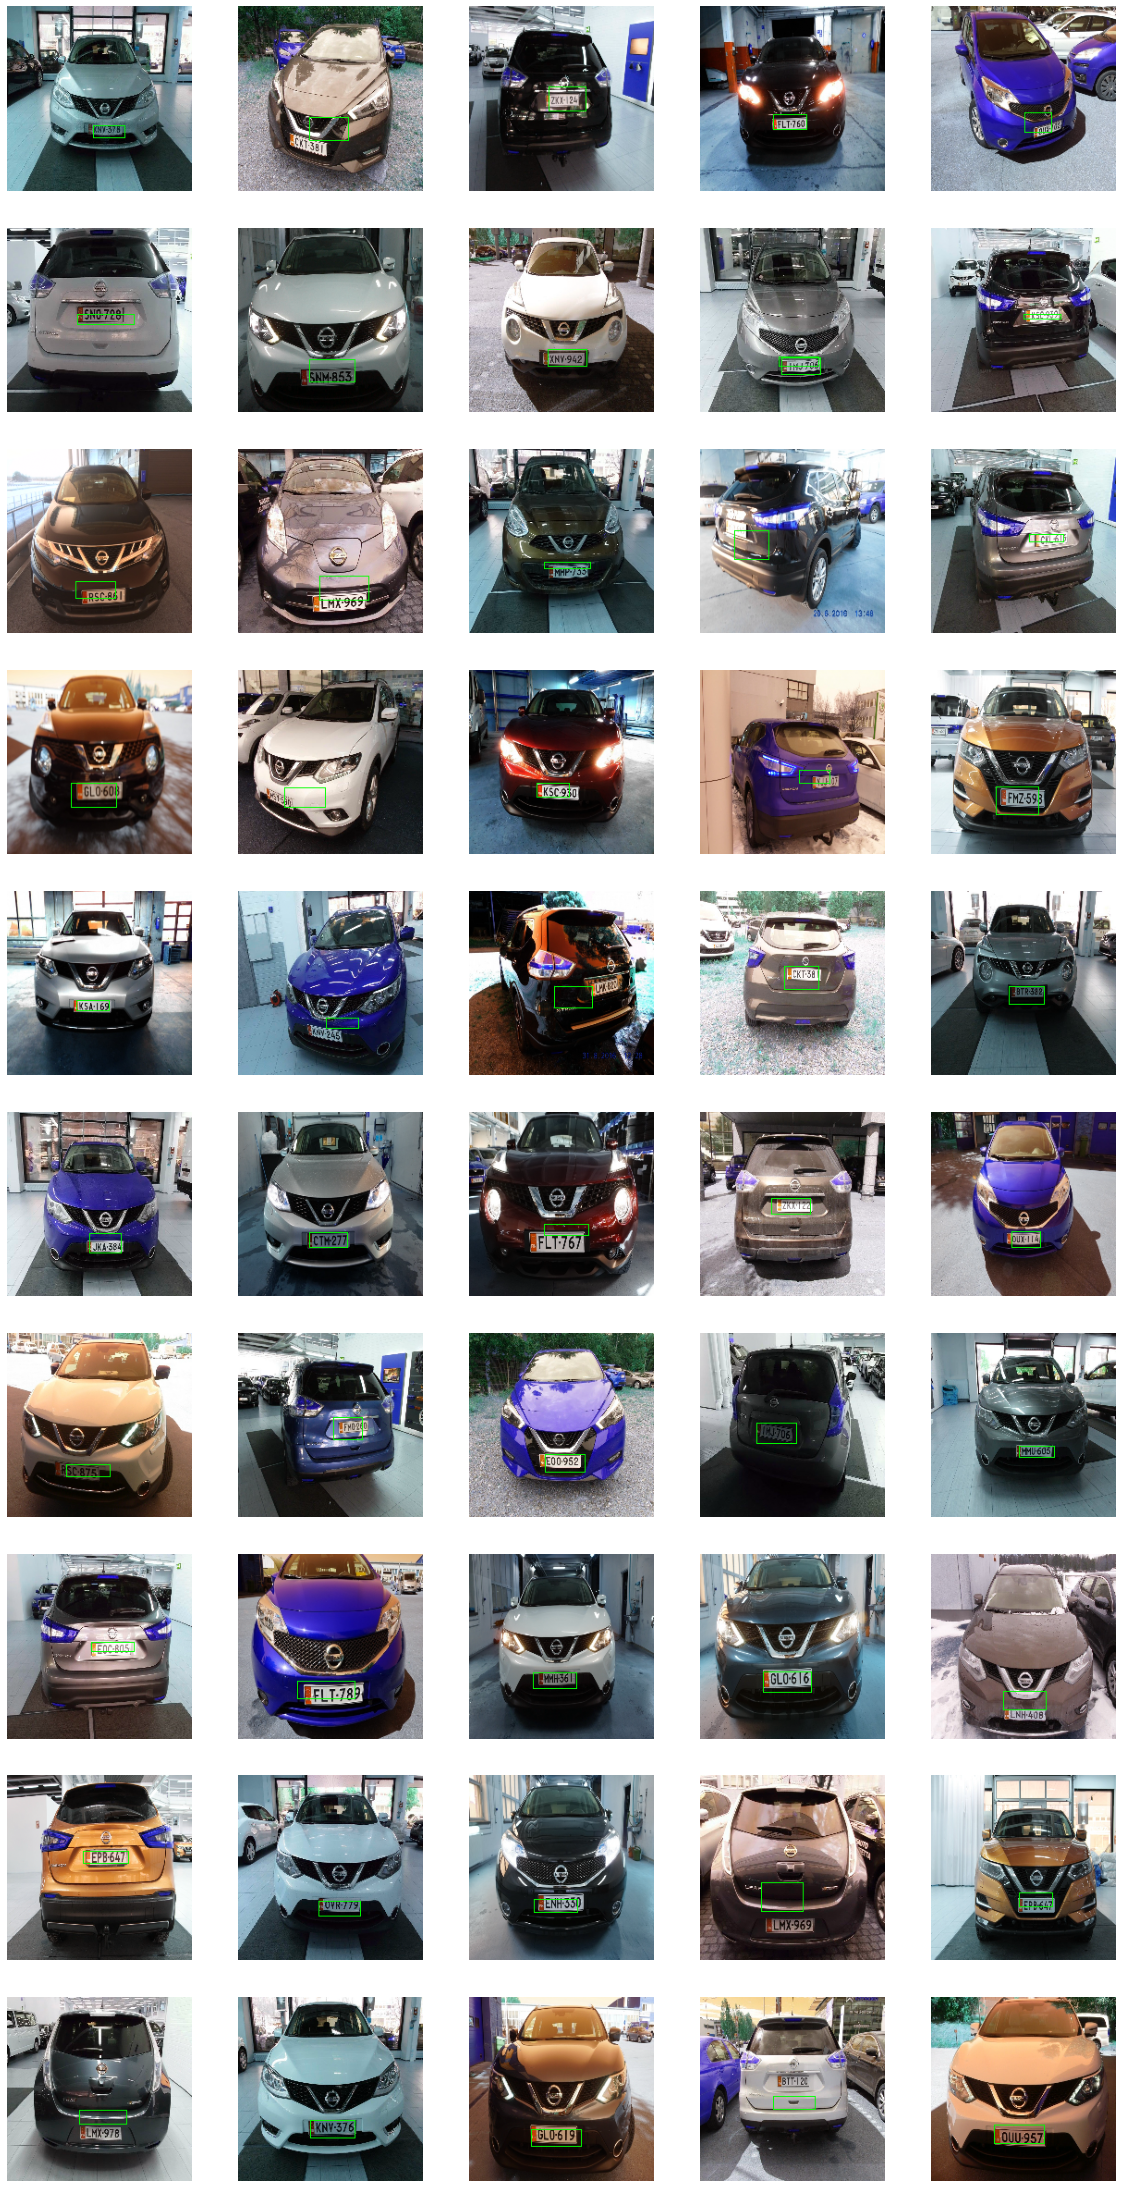

In [17]:
plt.figure(figsize=(20,40))

max = y_cnn.shape[0]
if max > 50:
    max = 50

for i in range(0,max):
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

9. Crop images around the area of the plate prediction

In [18]:
plt.figure(figsize=(20,400))

max = y_cnn.shape[0]
RANGE = 60
for i in range(0,max):
    # Read image from original folder
    image_name = str(i+1) + '.jpg'
    output_folder = './data/output/'
    input_folder = './data/images/'
    image = cv2.imread(input_folder + image_name)
    
    # Get image shape and get the factor to convert to original annotation
    h, w, c = image.shape    
    w_ratio = w / IMAGE_SIZE
    h_ratio = h / IMAGE_SIZE

    # cropped_image = gray[x1:x2+1, y1:y2+1]
    x1 = int(ny[0])-RANGE
    x2 = int(ny[1])+RANGE
    y1 = int(ny[2])-RANGE
    y2 = int(ny[3])+RANGE
    if x1 < 0: x1=0
    if y1 < 0: y1=0    

    x1 = int(x1 * w_ratio)
    x2 = int(x2 * w_ratio)
    y1 = int(y1 * h_ratio)
    y2 = int(y2 * h_ratio)

    cropped_image = image[x1:x2,y1:y2]    

    # Create the directory if it does not exist 
    if not (os.path.exists(output_folder)):
        os.makedirs(output_folder)

    cv2.imwrite(output_folder + image_name, cropped_image) 

<Figure size 1440x28800 with 0 Axes>

10. Read in a randomly selected Image, Grayscale and Blur it

./data/output/35.jpg


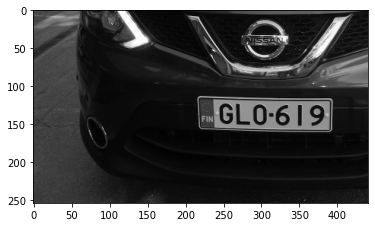

In [29]:
import random 
n = random.randint(1,max)
image_name = './data/output/' + str(n) + '.jpg'
print(image_name)
img = cv2.imread(image_name)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

11. Apply filter and find edges for localization

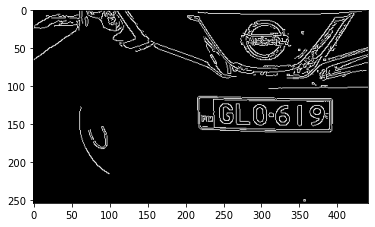

In [30]:
bfilter = cv2.bilateralFilter(gray, 13, 15, 15) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

12. Find Contours and apply mask

In [31]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [32]:
for c in contours:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.18 * peri, True)
    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

In [33]:
screenCnt

NameError: name 'screenCnt' is not defined

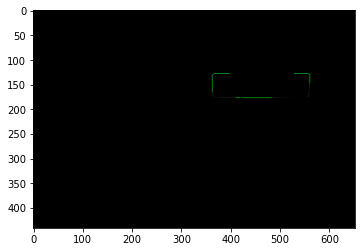

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

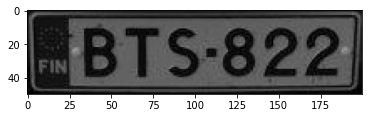

In [186]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [109]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[3, 1], [161, 1], [161, 44], [3, 44]], 'GLR277', 0.9536456613683191)]

In [110]:
for r in result:
    print(np.sum(np.subtract(r[0][1], r[0][0])))

158


In [111]:
region_threshold = 0.6

In [112]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]

    plate = []

    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))

        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [113]:
plate = filter_text(cropped_image, result, region_threshold)

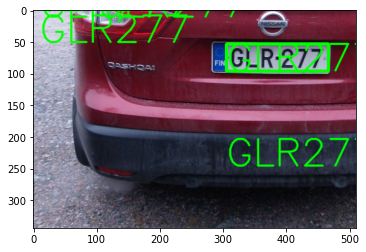

In [120]:
text = plate[0]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(10, 50), fontFace=font, fontScale=2, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [ ]:
image = cv2.imread(image_name)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)
height, width, channel = image.shape
# Find contours
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
image_area = 4*height*width
print("Image area:", image_area)
# #Iterate thorugh contours and draw rectangles around contours
# for c in cnts:
#     x,y,w,h = cv2.boundingRect(c)
#     cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

largest_area = 0
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    print( x,y,w,h )
    area = 4*w*h
    if ((4*w) > h): 
      if (area < 0.08*image_area):  
            if area > largest_area:
                largest_area = area
                largest_area_contour = c    
                print(largest_area)


x,y,w,h = cv2.boundingRect(largest_area_contour)
cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

cv2.imshow('canny', canny)
cv2.imshow('image', image)
cv2.imwrite('canny.png', canny)
cv2.imwrite('image.png', image)
cv2.waitKey(0)

screenCnt = largest_area_contour
print(screenCnt)
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [screenCnt], 0,255, -1)
new_image = cv2.bitwise_and(image, image, mask=mask)